In [1]:
allow_train = True
freeze_encoder = False
EPOCHS = 20
BATCH_SIZE = 128
shrink_size = None

In [2]:
import torch
import torchvision
from torch import nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from torchinfo import summary
from going_modular import engine, utils
from going_modular import custom_data_setup_pre_train
import helper_functions

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
c:\Users\User\.conda\envs\EnvCuda\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
c:\Users\User\.conda\envs\EnvCuda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set matmul precision for TF32 usage on Ampere+ GPUs
# torch.set_float32_matmul_precision('medium')

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Augmentation

In [ ]:
no_transforms = A.Compose([
    A.Resize(240, 240),       
    A.ToFloat(),
    ToTensorV2()
], seed=33)

p = 0.2

A_transforms = A.Compose([ 
    # A.Resize(240, 240),
    A.Resize(380, 380),
    A.OpticalDistortion(distort_limit=0.3, p=p),
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=p),
    A.ElasticTransform(alpha=40, sigma=50, p=p),
    A.Affine(scale=[0.7, 1.4], translate_percent=[-0.05, 0.05], shear=[-15, 15], rotate=[-45, 45], p=p),
    A.HorizontalFlip(p=p), 
    A.VerticalFlip(p=p), 
    A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=p),  
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=p),  
    A.AdditiveNoise(noise_type='gaussian', spatial_mode='shared', approximation=1.0, noise_params={"mean_range": (0.0, 0.0), "std_range": (0.02, 0.05)}, p=p),
    A.GaussianBlur(blur_limit=1, p=p), 
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=p),  
    A.Emboss(alpha=(0.5, 0.6), strength=(0.6, 0.7), p=p),  
    A.RandomGamma(gamma_limit=(80, 120), p=p),  
    A.CoarseDropout(num_holes_range=(1, 2), hole_height_range=(0.1, 0.2), hole_width_range=(0.1, 0.2), fill=0, fill_mask=None, p=p),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.ToFloat(),
    ToTensorV2()
], seed=33)

In [5]:
exp_dataloader, class_names = custom_data_setup_pre_train.create_test_dataloader(transform=no_transforms,
                                                                                        batch_size=BATCH_SIZE,
                                                                                        shrink_size=shrink_size) 

test_dataloader, class_names = custom_data_setup_pre_train.create_test_dataloader(transform=A_transforms, 
                                                                                        batch_size=BATCH_SIZE,
                                                                                        shrink_size=shrink_size) 

train_dataloader, class_names = custom_data_setup_pre_train.create_train_dataloader(transform=A_transforms, 
                                                                                        batch_size=BATCH_SIZE,
                                                                                        shrink_size=shrink_size) 

In [6]:
from going_modular.custom_data_setup_main_train import LoadDataset

IDRID_image_folder = "../../IDRID/Imagenes/Imagenes" 
IDRID_csv_file = "../../IDRID/idrid_labels.csv"  

MESSIDOR_image_folder = "../../MESSIDOR/images"
MESSIDOR_csv_file = "../../MESSIDOR/messidor_data.csv"

APTOS_train_image_folder = "../../APTOS/resized_train_19"
APTOS_train_csv_file = "../../APTOS/labels/trainLabels19.csv"  

APTOS_test_image_folder = "../../APTOS/resized_test_15"
APTOS_test_csv_file = "../../APTOS/labels/testLabels15.csv"  

test_dataset_with_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=A_transforms)
test_dataset_no_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=no_transforms)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


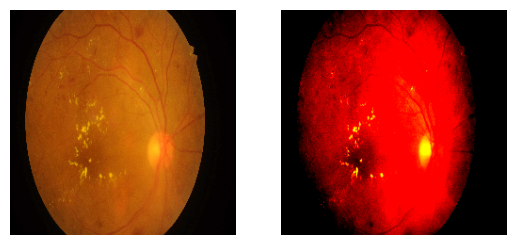

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


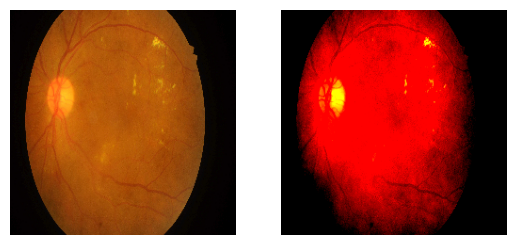

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


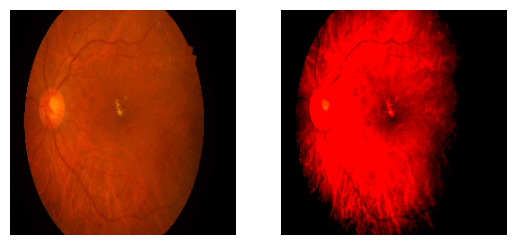

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


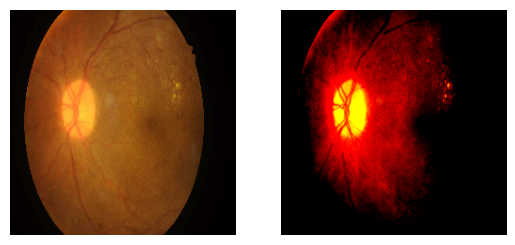

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


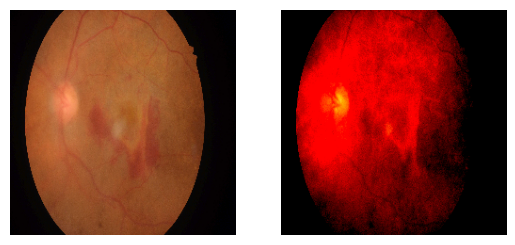

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


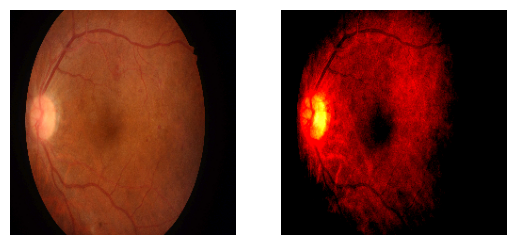

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.3070468].


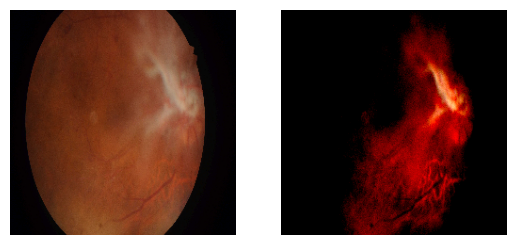

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


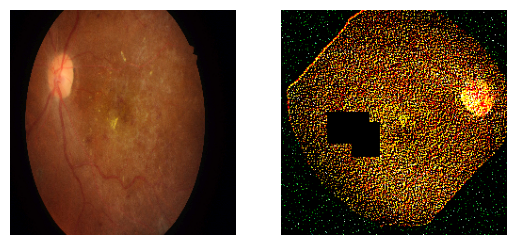

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


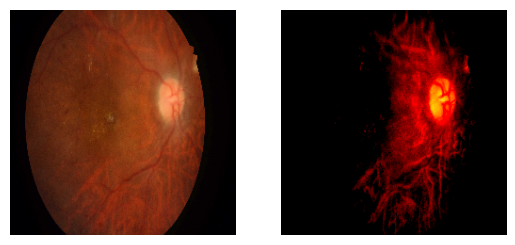

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3235292].


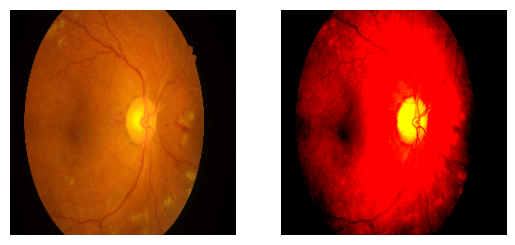

In [7]:
for i in range(10):
    img_2 = test_dataset_with_transform[i][0].permute(1, 2, 0)
    img_1 = test_dataset_no_transform[i][0].permute(1, 2, 0)
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img_1.numpy())
    axes[1].imshow(img_2.numpy())
    axes[0].axis(False)
    axes[1].axis(False)
    plt.show()

In [ ]:
class ThreeHeadCNN(nn.Module):
    def __init__(self):
        super(ThreeHeadCNN, self).__init__()

        # Load EfficientNet encoder
        weights = torchvision.models.EfficientNet_B4_Weights.DEFAULT
        efficientNet = torchvision.models.efficientnet_b4(weights=weights)
        self.encoder = efficientNet.features

        # Pooling layers
        self.global_max_pool = nn.AdaptiveMaxPool2d(1)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.batch_norm_1= nn.BatchNorm1d(1280) 
        self.batch_norm_2= nn.BatchNorm1d(1280)

        self.dense1 = nn.Linear(1280 * 2, 512)


        # Classification head
        self.classification_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 5) # 5 output nodes for classification
        )

        # Regression head
        self.regression_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 1) # 1 output node is for regression
        )

        # Ordinal regression head
        self.ordinal_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 5) # 5 output nodes for ordinal regression
        )

        # self.final_head = nn.Linear(11, 1)

    def forward(self, x):
        x = self.encoder(x) # Extract features

        # Apply pooling layers
        max_pooled = self.global_max_pool(x).view(x.size(0), -1)
        avg_pooled = self.global_avg_pool(x).view(x.size(0), -1)

        # Concatenate
        x1 = self.batch_norm_1(max_pooled)
        x2 = self.batch_norm_2(avg_pooled)
        x = torch.concat([x1, x2], dim=1)
        x = torch.relu(self.dense1(x))

        # enc_out for visualizing data with t-SNE
        enc_out = x

        # Classification branch
        class_out = self.classification_head(x)

        # Regression branch
        reg_out = self.regression_head(x).squeeze(dim=1) # Single value

        # Ordinal regression branch
        ord_out = self.ordinal_head(x)

        # Final head branch
        # final_out = self.final_head(torch.concat([class_out, reg_out, ord_out], dim=1))

        return class_out, reg_out, ord_out, enc_out

    
model = ThreeHeadCNN().to(device)

In [9]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
if freeze_encoder:
    for param in model.encoder.parameters():
        param.requires_grad = False

In [10]:
# Print a summary using torchinfo (uncomment for actual output)
torch.manual_seed(33)
summary(model=model, 
        input_size=(32, 3, 240, 240), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ThreeHeadCNN (ThreeHeadCNN)                                  [32, 3, 240, 240]    [32, 5]              --                   True
├─Sequential (encoder)                                       [32, 3, 240, 240]    [32, 1280, 8, 8]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 240, 240]    [32, 32, 120, 120]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 240, 240]    [32, 32, 120, 120]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 120, 120]   [32, 32, 120, 120]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 120, 120]   [32, 32, 120, 120]   --                   --
│    └─Sequential (1)                                        [32, 32, 120, 120]   [32, 16, 120

In [11]:
# Define loss and optimizer
from torch.optim.lr_scheduler import CosineAnnealingLR
# weights = torch.Tensor([1.87, 12.61, 4.1, 14.9, 13.12]) * 0.2
# weights.to(device)
# loss_fn_classification = nn.CrossEntropyLoss(weight=weights).to(device)
loss_fn_classification = nn.CrossEntropyLoss().to(device)

# loss_fn_regression = nn.L1Loss(reduction='none').to(device)
loss_fn_regression = nn.L1Loss().to(device)

# loss_fn_ordinal = nn.BCEWithLogitsLoss(weight=weights).to(device)
loss_fn_ordinal = nn.BCEWithLogitsLoss().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=0.0)

In [12]:
train_results = []

if allow_train:
    # Set the random seeds
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    # Start the timer
    from timeit import default_timer as timer 
    start_time = timer()

    # Setup training and save the results
    train_results = engine.pre_train(model=model,
                            train_dataloader=train_dataloader,
                            optimizer=optimizer,
                            scheduler=scheduler,
                            loss_fn_classification=loss_fn_classification,
                            loss_fn_regression=loss_fn_regression,
                            loss_fn_ordinal=loss_fn_ordinal,
                            epochs=EPOCHS,
                            device=device)
        
    # End the timer and print out how long it took
    end_time = timer()
    print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

    utils.save_model(model=model, target_dir='models', model_name='pre_train_model.pth')
else:
    model.load_state_dict(torch.load('models/pre_train_model.pth', weights_only=True, map_location=device))

  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\User\AppData\Roaming\Python\Python312\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  5%|▌         | 1/20 [01:32<29:23, 92.81s/it]

Epoch: 1
loss_classification_train: 0.8500 | loss_regression_train: 0.5437 | loss_ordinal_train: 0.2949



  5%|▌         | 1/20 [01:50<35:01, 110.59s/it]


KeyboardInterrupt: 

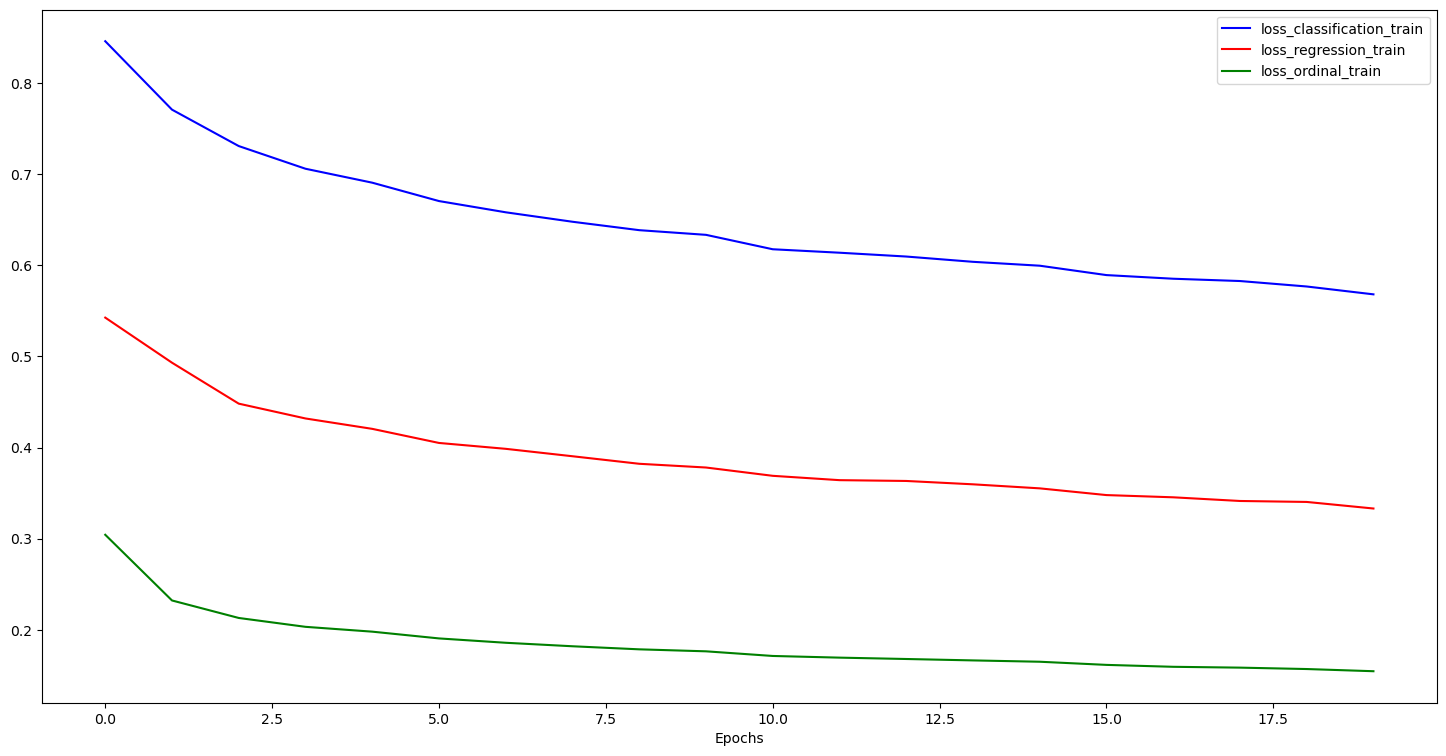

In [ ]:
if train_results:
    helper_functions.plot_loss_curves_pre_train(train_results)

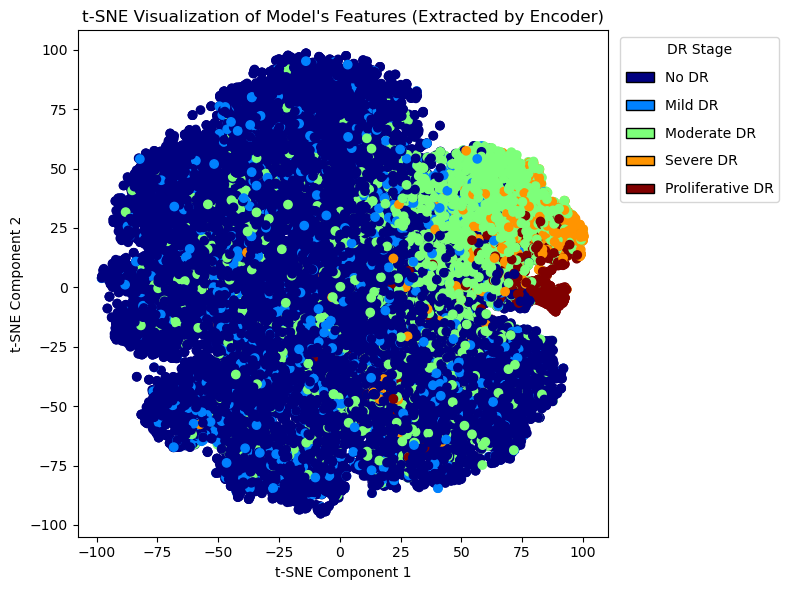

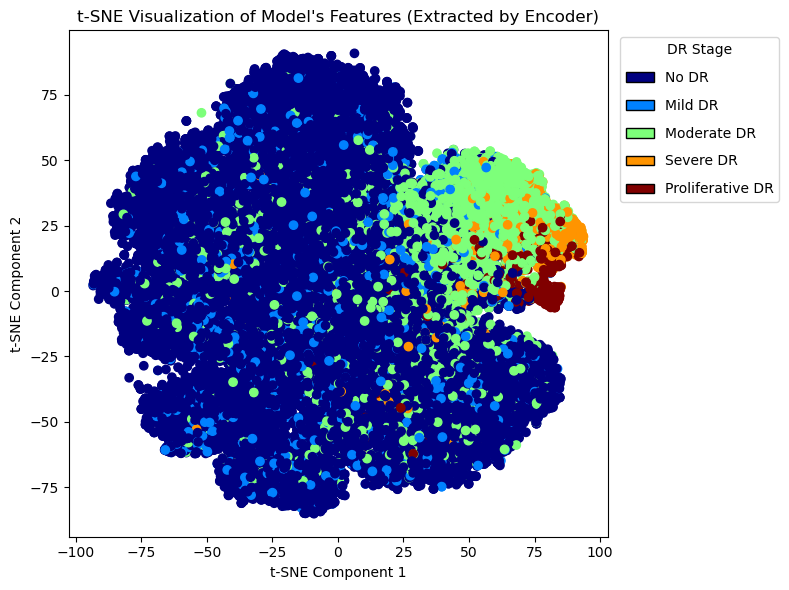

In [ ]:
helper_functions.plot_t_SNE(model=model,
                            dataloader=train_dataloader,
                            NUM_ITER=2000)

In [ ]:
test_results = engine.test_step(model=model,
            dataloader=test_dataloader,
            loss_fn_classification=loss_fn_classification,
            loss_fn_regression=loss_fn_regression,
            loss_fn_ordinal=loss_fn_ordinal,
            device=device)

f1_class: tensor([0.8962, 0.0238, 0.4691, 0.3138, 0.4026]) | f1_reg: tensor([0.8969, 0.0695, 0.4121, 0.2835, 0.2923]) | f1_ord: tensor([0.8967, 0.0659, 0.4723, 0.3334, 0.3789])
test class acc: 0.8005419649960223 | test reg acc: 0.7811919915141873 | test ord acc: 0.792897275258552
